In [1]:
# python
import os
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

import coffea.util
import mplhep as hep

In [2]:
import yaml
yaml_file_path = '../../configs/ntuples/signal_2mu2e_v10.yaml'
# Open and read the YAML file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)
signals_all = list(data["llpNanoAOD_v2"]["samples"].keys())




In [3]:
import numpy as np
dict_values ={100:{}, 150:{}, 200:{}, 500:{}, 800:{}, 1000:{}}
for key in dict_values.keys():
    dict_values[key] = {0.25:{}, 1.2:{}, 5:{}}
threshold = 2
output_signal = coffea.util.load( "output_signal_electron_base_ljObjCut_ljIso_2lj.coffea" )
for s in signals_all:
    parts = s.split("_")
    
    histogram = output_signal["out"][s]["hists"]["egm_lj_electron_lostHits"]["base_ljObjCut_ljIso_2lj", :]
    values = histogram.values()
    overflow = histogram.values(flow=True)[-1]
    # print(overflow)
    bin_edges = histogram.axes[0].edges
    idx = np.searchsorted(bin_edges, threshold, side="right")-1
    idx = max(0, idx)
    n_events = values[idx:].sum() + overflow
    n_events_total = values.sum() + overflow
    n_fraction = n_events/n_events_total
    # utilities.plot(histogram, density=True, yerr=False)
    mass = float(parts[1].replace("GeV", ""))
    zd_mass = float(parts[2].replace("p", ".").replace("GeV", ""))
    ctau = float(parts[3].replace("p", ".").replace("mm", ""))

    result = (mass, zd_mass, ctau)
    # print(result)
    dict_values[mass][zd_mass].update( { ctau: [ n_events, n_fraction]})
# print(dict_values)

In [4]:
dict_values_lxy= {100:{}, 150:{}, 200:{}, 500:{}, 800:{}, 1000:{}}
Lxy = [0.3, 3, 30, 150, 300]
for key in dict_values_lxy.keys():
    dict_values_lxy[key] = {0.25:{}, 1.2:{}, 5:{}}
for mass in dict_values:
    for zd_mass in dict_values[mass]:
         ctaus = sorted(list(dict_values[mass][zd_mass].keys()))
         for i in range(len(ctaus)):
             dict_values_lxy[mass][zd_mass].update( { Lxy[i]: dict_values[mass][zd_mass][ctaus[i]]})  
print(dict_values_lxy[100][0.25][0.3])

[0.009042077632834872, 0.0030458480282141718]


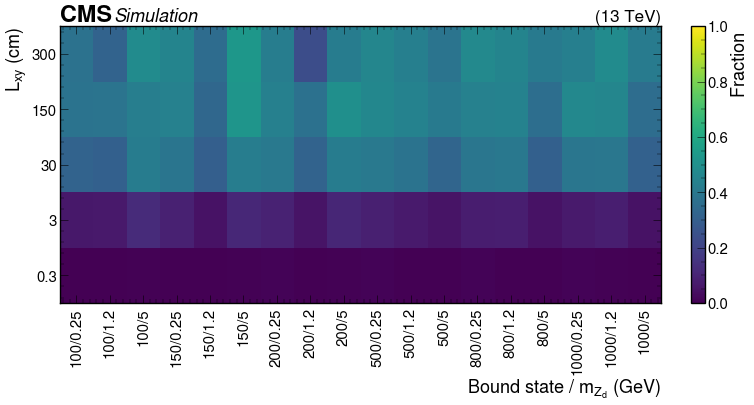

In [5]:
def plot_percentage_grid_all(data):
    import numpy as np
    import matplotlib.pyplot as plt

    # Collect all (bound_mass, zd_mass) pairs
    combos = []
    for mass, zd_dict in data.items():
        for zd in zd_dict.keys():
            combos.append((mass, zd))
    combos = sorted(combos, key=lambda x: (x[0], x[1]))

    # Collect all Lxy values (y-axis)
    lab_vals = sorted(set(
        lab for mass in data for zd in data[mass] for lab in data[mass][zd].keys()
    ))

    # Initialize grid for percentage
    z_percent = np.full((len(lab_vals), len(combos)), np.nan)

    # Fill grid
    for j, (mass, zd) in enumerate(combos):
        for i, lab in enumerate(lab_vals):
            values = data[mass][zd].get(lab, [np.nan, np.nan])
            z_percent[i, j] = values[1]

    # X-axis labels like "100/0.25"
    x_labels = [f"{m}/{zd}" for m, zd in combos]

    # --- Plot percentage ---
    fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)
    im = ax.imshow(
        z_percent,
        origin='lower',
        cmap='viridis',
        vmin=0, vmax=1,
        aspect='auto'
    )

    ax.set_xticks(np.arange(len(combos)))
    ax.set_xticklabels(x_labels, rotation=90)
    ax.set_yticks(np.arange(len(lab_vals)))
    ax.set_yticklabels(lab_vals)
    # ax.set_title(r"$d_{xy} > 0.025$ cm")
    ax.set_xlabel(r"Bound state / $m_{Z_d}$ (GeV)")
    ax.set_ylabel(r"$L_{xy}$ (cm)")
    plt.colorbar(im, ax=ax, label=r"Fraction " )
    hep.cms.label()

    plt.show()
    plt.close()

plot_percentage_grid_all(dict_values_lxy)

[0.2579371619471842, 0.0868868226995832]


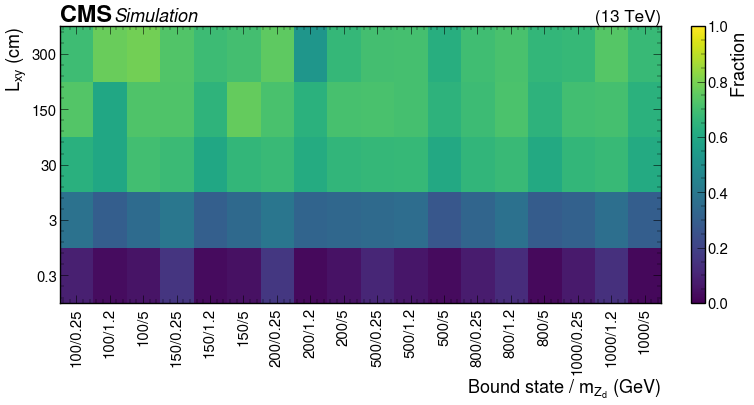

In [6]:
import numpy as np
dict_values ={100:{}, 150:{}, 200:{}, 500:{}, 800:{}, 1000:{}}
for key in dict_values.keys():
    dict_values[key] = {0.25:{}, 1.2:{}, 5:{}}
threshold = 1
output_signal = coffea.util.load( "output_signal_base_ljObjCut_ljIso_2lj.coffea" )
for s in signals_all:
    parts = s.split("_")
    
    histogram = output_signal["out"][s]["hists"]["egm_lj_electron_lostHits"]["base_ljObjCut_ljIso_2lj", :]
    values = histogram.values()
    overflow = histogram.values(flow=True)[-1]
    # print(overflow)
    bin_edges = histogram.axes[0].edges
    idx = np.searchsorted(bin_edges, threshold, side="right")-1
    idx = max(0, idx)
    n_events = values[idx:].sum() + overflow
    n_events_total = values.sum() + overflow
    n_fraction = n_events/n_events_total
    # utilities.plot(histogram, density=True, yerr=False)
    mass = float(parts[1].replace("GeV", ""))
    zd_mass = float(parts[2].replace("p", ".").replace("GeV", ""))
    ctau = float(parts[3].replace("p", ".").replace("mm", ""))

    result = (mass, zd_mass, ctau)
    # print(result)
    dict_values[mass][zd_mass].update( { ctau: [ n_events, n_fraction]})
# print(dict_values)
dict_values_lxy= {100:{}, 150:{}, 200:{}, 500:{}, 800:{}, 1000:{}}
Lxy = [0.3, 3, 30, 150, 300]
for key in dict_values_lxy.keys():
    dict_values_lxy[key] = {0.25:{}, 1.2:{}, 5:{}}
for mass in dict_values:
    for zd_mass in dict_values[mass]:
         ctaus = sorted(list(dict_values[mass][zd_mass].keys()))
         for i in range(len(ctaus)):
             dict_values_lxy[mass][zd_mass].update( { Lxy[i]: dict_values[mass][zd_mass][ctaus[i]]})  
print(dict_values_lxy[100][0.25][0.3])
plot_percentage_grid_all(dict_values_lxy)

[0.3455025453388482, 0.11772336630452405]


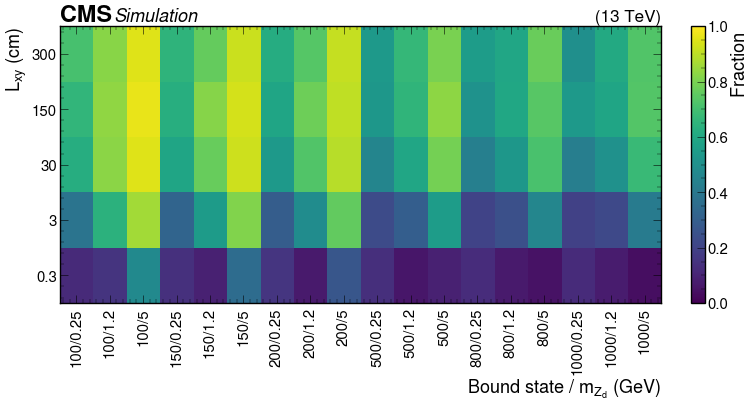

In [7]:

import numpy as np
dict_values ={100:{}, 150:{}, 200:{}, 500:{}, 800:{}, 1000:{}}
for key in dict_values.keys():
    dict_values[key] = {0.25:{}, 1.2:{}, 5:{}}
threshold = 0.01
output_signal = coffea.util.load( "output_signal_base_ljObjCut_ljIso_2lj.coffea" )
for s in signals_all:
    parts = s.split("_")
    
    histogram = output_signal["out"][s]["hists"]["egm_lj_electron_min_dxy_XXXLowRange"]["base_ljObjCut_ljIso_2lj", :]
    values = histogram.values()
    overflow = histogram.values(flow=True)[-1]
    # print(overflow)
    bin_edges = histogram.axes[0].edges
    idx = np.searchsorted(bin_edges, threshold, side="right")-1
    idx = max(0, idx)
    n_events = values[idx:].sum() + overflow
    n_events_total = values.sum() + overflow
    n_fraction = n_events/n_events_total
    # utilities.plot(histogram, density=True, yerr=False)
    mass = float(parts[1].replace("GeV", ""))
    zd_mass = float(parts[2].replace("p", ".").replace("GeV", ""))
    ctau = float(parts[3].replace("p", ".").replace("mm", ""))

    result = (mass, zd_mass, ctau)
    # print(result)
    dict_values[mass][zd_mass].update( { ctau: [ n_events, n_fraction]})
# print(dict_values)
dict_values_lxy= {100:{}, 150:{}, 200:{}, 500:{}, 800:{}, 1000:{}}
Lxy = [0.3, 3, 30, 150, 300]
for key in dict_values_lxy.keys():
    dict_values_lxy[key] = {0.25:{}, 1.2:{}, 5:{}}
for mass in dict_values:
    for zd_mass in dict_values[mass]:
         ctaus = sorted(list(dict_values[mass][zd_mass].keys()))
         for i in range(len(ctaus)):
             dict_values_lxy[mass][zd_mass].update( { Lxy[i]: dict_values[mass][zd_mass][ctaus[i]]})  
print(dict_values_lxy[100][0.25][0.3])
plot_percentage_grid_all(dict_values_lxy)